In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from collections import defaultdict

In [3]:
pd.options.mode.chained_assignment = None

## Przegląd danych

In [4]:
seed = 20

df = pd.read_stata('../data/HCMST 2017 fresh sample for public sharing draft v1.1.dta')
df.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Wybrane zmienne

* Numeryczne
    * age_when_met 
    * time_from_met_to_rel
<br><br>
* Kategoryczne
    * ppagecat
    * ppincimp

In [5]:
num_feature1 = 'age_when_met'  # age when met in years,
num_feature2 = 'time_from_met_to_rel'  # Time from meeting to relationship
cat_feature1 = 'ppagecat'  # Age - 7 Categories
cat_feature2 = 'ppincimp'  # Household Income 
label = 'S1'  # Are you married?

#### Zakodowanie danych kategorycznych

In [6]:
incomes = [
    'Less than $5,000',
    '$5,000 to $7,499',
    '$7,500 to $9,999',
    '$10,000 to $12,499', 
    '$12,500 to $14,999',
    '$15,000 to $19,999',
    '$20,000 to $24,999',
    '$25,000 to $29,999',
    '$30,000 to $34,999',
    '$35,000 to $39,999',
    '$40,000 to $49,999',
    '$50,000 to $59,999',
    '$60,000 to $74,999',
    '$75,000 to $84,999',
    '$85,000 to $99,999',
    '$100,000 to $124,999', 
    '$125,000 to $149,999', 
    '$150,000 to $174,999', 
    '$175,000 to $199,999', 
    '$200,000 to $249,999', 
    '$250,000 or more',      
]

ages = [
    '18-24', 
    '25-34', 
    '35-44', 
    '45-54', 
    '55-64', 
    '65-74', 
    '75+'
]

income_encoder = {inc: i for i, inc in enumerate(incomes)}
age_encoder = {age: i for i, age in enumerate(ages)}

In [7]:
df = df[[num_feature1, num_feature2, cat_feature1, cat_feature2, label]]
df = df.dropna()

df[cat_feature1] = df[cat_feature1].apply(lambda x: age_encoder[x]).astype(np.int)
df[cat_feature2] = df[cat_feature2].apply(lambda x: income_encoder[x]).astype(np.int) 
df[label] = df[label].apply(lambda x: 1 if x == 'Yes, I am Married' else 0)
df.head()

,age_when_met,time_from_met_to_rel,ppagecat,ppincimp,S1
0,30.0,0.000000,1,10,0
1,21.0,12.250000,4,17,1
2,36.0,0.416748,3,19,1
3,23.0,1.083252,1,10,0
4,25.0,0.083252,4,18,1


#### Podział na zbiory - treningowy i testowy

In [8]:
X = df.drop(label, axis=1)
y = df[label]
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=seed)

## Trening i walidacja modelu

In [9]:
models = {
    'xgboost': xgb.sklearn.XGBClassifier(learning_rate=0.01, n_estimators=300, reg_lambda=9, n_jobs=-1, random_state=seed),
    'svm': SVC(gamma='scale', probability=True, random_state=seed),
    'logistic regression': LogisticRegression(solver='lbfgs', random_state=seed),
    'random forest': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed),
}

for _, model in models.items():
    model.fit(train_X, train_y)

In [10]:
for name, model in models.items():
    pred_y = model.predict(test_X)
    score = accuracy_score(pred_y, test_y)
    print(f'Accuracy: {(score*100):.2f}% - {name}')

Accuracy: 77.82% - xgboost
Accuracy: 77.70% - svm
Accuracy: 77.45% - logistic regression
Accuracy: 74.75% - random forest


### Wpływ zmiennych na działanie modeli

In [11]:
def feature_importance(model, x, y):
    accs = defaultdict(list)
    original_acc = accuracy_score(y, model.predict(x))
    for i in range(100):
        for col in x.columns:
            tmp_x = x.copy()
            tmp_x[col] = np.random.permutation(tmp_x[col].values)
            pred_y = model.predict(tmp_x)
            feature_acc = accuracy_score(y, pred_y)
            accs[col].append(original_acc - feature_acc)
    for k in accs:
        accs[k] = np.mean(accs[k])
    return accs

In [12]:
importances = {}

for name, model in models.items():
    custom_imp = feature_importance(model, test_X, test_y)
    importances[name] = custom_imp

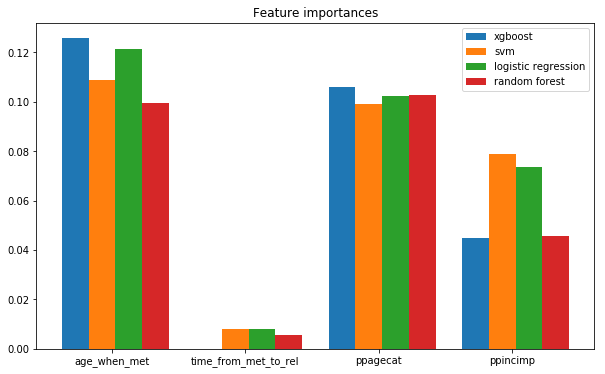

In [13]:
bar_width = 0.2
plt.figure(figsize=(10,6))
for i, (name, model_importances) in enumerate(importances.items()):
    plt.bar(np.arange(len(model_importances))+i*bar_width, model_importances.values(), bar_width, label=name)

plt.xticks(np.array(range(len(custom_imp)))+bar_width*len(importances)/2-1/8, custom_imp.keys())
plt.title('Feature importances')
plt.legend()
plt.show()

### Porównanie ALEplots dla wybranej zmiennej

In [14]:
def calculate_ALE(model, df, feature, n_points):
    f_min, f_max = df[feature].min(), df[feature].max() 
    f_idx = df.columns.get_loc(feature)
    grid_values = np.linspace(f_min, f_max, n_points)
    accumulated_effects = [0]
     
    for i in range(n_points-1):
        val_a, val_b = grid_values[i], grid_values[i+1]
        samples = df.loc[(df[feature] >= val_a) & (df[feature] < val_b), :]
        samples[feature] = val_a
        if len(samples) == 0:
            accumulated_effects.append(accumulated_effects[-1])
        else:
            preds_a = model.predict_proba(samples)[:, 1]
            samples.loc[:, feature] = val_b
            preds_b = model.predict_proba(samples)[:, 1]
            local_effect = np.mean(preds_b - preds_a)
            acc_loc_effect = accumulated_effects[-1] + local_effect
            accumulated_effects.append(acc_loc_effect)
    
    return grid_values, accumulated_effects


def compare_ALE(models, x, feature, n_points):
    fig = plt.figure(figsize=(15, 8))
    for name, model in models.items():
        ale_vals = calculate_ALE(model, x, feature, n_points)
        plt.plot(ale_vals[0], ale_vals[1], label=name)

    plt.title(f'ALE plot for feature {feature}')
    plt.legend()
    plt.show()

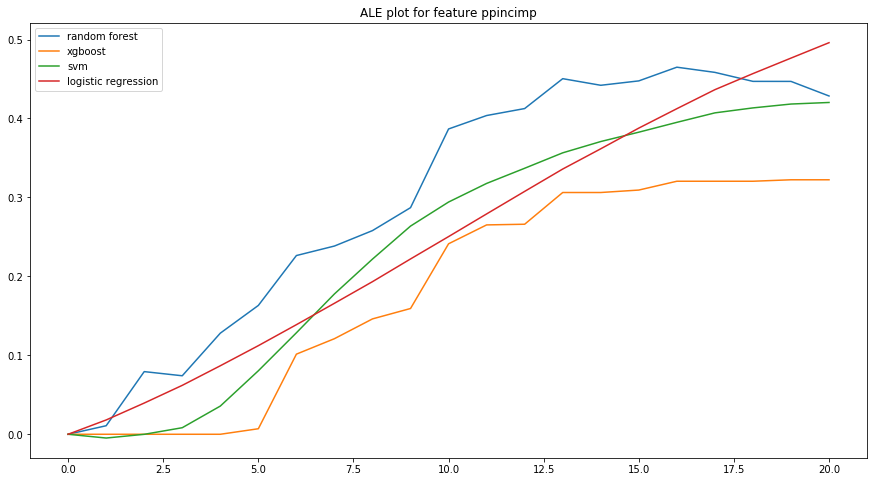

In [15]:
chosen_models = ['random forest', 'xgboost', 'svm', 'logistic regression']
to_compare = {name: models[name] for name in chosen_models}

compare_ALE(to_compare, train_X, 'ppincimp', 21)

### Wnioski

Z pierwszego wykresu porównującego ważność zmiennych widać, że mają one porównywalny wpływ na wybrane modele. Największe różnice występują przy zmiennej **ppincimp**, która ma mniejszy wpływ na modele oparte na drzewach (xgboost, random forest).

Po narysowaniu wykresów ALE dla wszystkich modeli, można ozauważyć, że te 2 modele zachowują się bardzo podobnie, jednak xgboost wykazuje mniejszą zmienność co może być przyczyną zastosowania silniejszej regularyzacji. Pozostałe modele wykazują podobny trend wzrostowy. Dla regresji logistycznej wykres jest liniowy co jest spowodowane naturą tego klasyfikatora. Widać także, że SVM cechuje się dużo mniejszą zmiennością i płynnym wykresem w porównaniu z modelami drzewiastymi.  